# Menu <a class="anchor" id="menu"></a>
   
* [1. Préparatifs](#init)
* [2. Recherche de l'`architecture` la plus adaptée](#ARCHI)
    * [2.1 `Archi-REF` Bi-LSTM 32 + Dropout 0.5](#ARCHI_REF)
    * [2.2 `Archi-000` Dense 32 + Dropout 0.5](#ARCHI_000)
    * [2.3 `Archi-100` Simple RNN 32 + Dropout 0.5](#ARCHI_100)
    * [2.4 `Archi-200` LSTM 32 + Dropout 0.5](#ARCHI_200)
    * [2.5 `Archi-300` GRU 32 + Dropout 0.5](#ARCHI_300)
    * [2.6 `Archi-201` Bi-LSTM 64 + Dropout 0.5](#ARCHI_201)
    * [2.7 `Archi-202` Bi-LSTM 64 + Dense 24](#ARCHI_202)
    * [2.8 `Archi-301` Bi-GRU 64 + Dropout 0.5](#ARCHI_301)
    * [2.9 `Archi-302` Bi-GRU 64 + Dense 24](#ARCHI_302)
    * [2.10 `Archi-401` Bi-LSTM 32 + Dense 10](#ARCHI_401)
    * [2.11 `Archi-402` Bi-LSTM 64 Seq + Dropout 0.2 + Bi-LSTM 32 + Dropout 0.2 + Dense 64 + Dropout 0.1](#ARCHI_402)
    * [2.13 Comparaison des scores](#ARCHI_scores)

In [1]:
!pip install dagshub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 596 kB 33.5 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import time
import pathlib
import gzip

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from dagshub import dagshub_logger, DAGsHubLogger

try:
    from tensorflow.keras.layers import TextVectorization
except ImportError:
    from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# set random seed for reproductibility
random_seed = 0
np.random.seed(random_seed)

try:
    keras.utils.set_random_seed(random_seed)
except Exception:
    tf.random.set_seed(random_seed)

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
os.chdir("/content/drive/MyDrive/Openclassrooms/AI_P7")

In [6]:
os.getcwd()

'/content/drive/MyDrive/Openclassrooms/AI_P7'

---
---
# 1. Préparatifs pour de la classification avec des réseaux de neurones <a class="anchor" id="init"></a> [⇪](#menu)

### Chargeons quelques fonctions *maison* pour entrainer et évaluer les modèles, et initialisons un fichier pour enregistrer les scores
Ces fonctions ont été déportées dans le fichier classification_utils.py pour allèger le notebook

In [7]:
# Load classification helpers' functions & initialize a file to log the models' scores
from classification_utils import fit_model, get_scores, init_scores, find_best_threshold
init_scores("data/scores_NN_SelectArchitecture.csv")

### Chargeons le jeu de données et préparons un `échantillon de travail` représentatif

In [9]:
data_work = pd.read_csv(
    pathlib.Path(pathlib.Path().absolute(), 'data', 'data_nlp_1563108.csv'), 
    usecols=['target', 'lemmas_not_filtered'],
    encoding='ISO-8859-1',
    #nrows=100000,
)
data_work.rename(columns={'lemmas_not_filtered':'text'}, inplace=True)
display(data_work.head(), data_work.shape)

# Select samples
#sample_size = 100000
#data_work = data_work.groupby('target', group_keys=False).apply(lambda x: x.sample(sample_size//2, random_state=random_seed))
#display(data_work.head(), data_work.shape)

,target,text
0,0,"$ url$ - awww , that be a bummer . you shoulda..."
1,0,be upset that he can not update his facebook b...
2,0,I dive many time for the ball . manage to save...
3,0,my whole body feel itchy and like its on fire
4,0,"no , it be not behave at all . I be mad . why ..."


(1452791, 2)

In [10]:
data_work.target.value_counts(dropna=False)

0    731641
1    721150
Name: target, dtype: int64

### Définissons les différentes `architectures RNN` que nous aimerions comparer

#### L'architecture utilisée sur les précèdents notebooks

In [11]:
# P.336 livre "Deep Learning with Python 2nd edition"
def architectureREF(f_opti, f_loss, f_metrics, embedding):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(x) # 64
    x = layers.Dropout(0.5)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model, "Bi-LSTM 32 + Dropout 0.5"

In [12]:
# P.323 livre "Deep Learning with Python 2nd edition"
def architecture000(f_opti, f_loss, f_metrics, embedding):
        
    max_tokens = 60
    inputs = keras.Input(shape=(max_tokens,), dtype="int64")
    
    #x = embedding(inputs)
    x = layers.Dense(32, activation='relu')(inputs)
    x = layers.Dropout(0.5)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model, "Dense 32 + Dropout 0.5"

#### Simple RNN / LSTM / GRU

In [13]:
# Simple RNN
def architecture100(f_opti, f_loss, f_metrics, embedding):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.SimpleRNN(32)(x)
    #x = layers.Dense(24, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model, "Simple RNN 32 + Dropout 0.5"

In [14]:
# LSTM 32
def architecture200(f_opti, f_loss, f_metrics, embedding):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.LSTM(32)(x)
    #x = layers.Dense(24, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model, "LSTM 32 + Dropout 0.5"

In [15]:
# GRU 32
def architecture300(f_opti, f_loss, f_metrics, embedding):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.GRU(32)(x)
    #x = layers.Dense(24, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model, "GRU 32 + Dropout 0.5"

#### Birectional RNN / LSTM / GRU

In [16]:
def architecture201(f_opti, f_loss, f_metrics, embedding):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.Bidirectional(layers.LSTM(64))(x)
    #x = layers.Dense(24, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model, "Bi-LSTM 64 + Dropout 0.5"

In [17]:
# https://www.analyticsvidhya.com/blog/2022/01/sentiment-analysis-with-lstm/
def architecture202(f_opti, f_loss, f_metrics, embedding):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.Bidirectional(layers.LSTM(64))(x)
    x = layers.Dense(24, activation='relu')(x)
    # x = layers.Dropout(0.5)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model, "Bi-LSTM 64 + Dense 24"

In [18]:
def architecture301(f_opti, f_loss, f_metrics, embedding):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.Bidirectional(layers.GRU(64))(x)
    #x = layers.Dense(24, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model, "Bi-GRU 64 + Dropout 0.5"

In [19]:
def architecture302(f_opti, f_loss, f_metrics, embedding):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.Bidirectional(layers.GRU(64))(x)
    x = layers.Dense(24, activation='relu')(x)
    # x = layers.Dropout(0.5)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model, "Bi-GRU 64 + Dense 24"

#### Quelques architectures trouvées dans mes lectures

In [20]:
# https://www.embedded-robotics.com/sentiment-analysis-using-lstm/
def architecture401(f_opti, f_loss, f_metrics, embedding):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(x)
    x = layers.Dense(10, activation='relu')(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model, "Bi-LSTM 32 + Dense 10"

In [21]:
# https://www.analyticsvidhya.com/blog/2021/08/sentiment-analysis-using-bidirectional-stacked-lstm/
def architecture402(f_opti, f_loss, f_metrics, embedding):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, input_shape=(None, 1)))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Bidirectional(layers.LSTM(32))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model, "Bi-LSTM 64 Seq + Dropout 0.2 + Bi-LSTM 32 + Dropout 0.2 + Dense 64 + Dropout 0.1"

### Définissons les fonctions utiles à l'`embedding`

In [22]:
## EMBEDDING ##

from gensim.models import KeyedVectors
import gensim.downloader as api

def load_gensim_embedding(embedding_name, binary=False):
    
    embedding_path = pathlib.Path(pathlib.Path().absolute(), 'data', 'embedding_models', f'{embedding_name}.gz')
    try:
        if embedding_path.is_file():
            print(f"Loading from {embedding_path}")
            embedding_model = KeyedVectors.load_word2vec_format(embedding_path, binary=binary)
        else:
            print("Loading from the Git repos with API")
            embedding_model = api.load(embedding_name)
            
        return embedding_model
    except Exception as e:
        print(f"The provided embedding model couldn't be loaded correctly: {e}")
        
def convert_embedding_matrix(vocabulary, embeddings_index, max_tokens, embedding_dim=100):
    
    hits = 0
    misses = 0
    misses_list = []
    
    word_index = dict(zip(vocabulary, range(len(vocabulary))))
    
    embedding_matrix = np.zeros((max_tokens, embedding_dim))
    
    for word, i in word_index.items():
        if i < max_tokens:
            try:
                embedding_vector = embeddings_index.get_vector(word)
            except AttributeError:
                embedding_vector = embeddings_index.get(word)
            except KeyError:
                embedding_vector = None
        if embedding_vector is not None:
            hits += 1
            embedding_matrix[i] = embedding_vector
        else:
            misses += 1
            misses_list.append(word)
            
    print(f"Converted {hits} words, and couldn't find {misses} words")
    print(f"Missing words: {misses_list}")
            
    return embedding_matrix

### Définissons les `fonctions et paramètres commun` à l'entrainement des différents modèles que l'on veut tester

In [23]:
# DagsHub 

def save_hyperparameters_to_dagshub(dlogger, model_name, archi_desc, layers, batch_size, sample_size):    
    dlogger.log_hyperparams(model_name=model_name)
    dlogger.log_hyperparams(archi_desc=archi_desc)
    dlogger.log_hyperparams(layers=layers)
    dlogger.log_hyperparams(batch_size=batch_size)
    dlogger.log_hyperparams(sample_size=sample_size)
    
def save_metrics_to_dagshub(dlogger, scores, best_threshold, history, step_num=1000, close=True):
    dlogger.log_metrics(scores, step_num=step_num)
    dlogger.log_metrics(best_threshold=best_threshold, step_num=step_num)
    add_scores_to_dagshub(dlogger, history)

def get_layers_for_dagshub(model):
    
    layers_infos = []
    
    def search(layer):
        layer = dict(layer)
        
        nonlocal layers_infos
        
        if 'config' in layer:
    
            #if 'name' in layer['config']:
            #    print(" name:", layer['config']['name'])
            conf = {}
            if 'units' in layer['config']:
                conf["units"] = layer['config']['units']
            if 'output_dim' in layer['config']:
                conf['output_dim'] = layer['config']['output_dim']
            if 'rate' in layer['config']:
                conf['rate'] = layer['config']['rate']
            
            layers_infos.append((layer['class_name'], conf))
            
            if 'layer' in layer['config']:
                search(layer['config']['layer'])
        
    for layer in model.get_config()['layers']:
        search(layer)
        
    return layers_infos


def add_scores_to_dagshub(dlogger, history):
    for epoch, loss, accuracy, val_loss, val_accuracy in zip(
        history.epoch, 
        history.history['loss'], 
        history.history['accuracy'], 
        history.history['val_loss'], 
        history.history['val_accuracy']):
        scores = {
            'loss':loss, 
            'accuracy':accuracy, 
            'val_loss':val_loss, 
            'val_accuracy':val_accuracy
        }
        dlogger.log_metrics(scores, step_num=epoch) 

In [24]:
def summarize_diagnostics(history):
    
    figure = plt.figure(figsize=(8,8))
            
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
    plt.legend()
    
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='val')
    plt.legend()
    
    # save plot to file
    #filename = sys.argv[0].split('/')[-1]
    #plt.savefig(filename + '_plot.png')
    #plt.close()
    
    plt.tight_layout(pad=1.0)

In [25]:
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau

def init_callbacks(model_name):

    # Define savepoints
    filepath = pathlib.Path("models", f"{model_name}.keras")

    checkpoint = ModelCheckpoint(
        monitor="val_accuracy",
        mode="max",
        filepath=filepath,
        save_best_only=True,
        verbose=1,
    )

    # Define EarlyStopping conditions
    es = EarlyStopping(
        monitor='val_loss', # 'binary_accuracy'
        mode='min', # 'max'
        patience=5,
        min_delta=0.01, 
        restore_best_weights=True, 
        verbose=1,
    )
    
    return [checkpoint, es]

In [25]:
batch_size=4096

### Divisons le jeu de données en `Train`, `Valid` et `Test` sets

In [31]:
X_train_full, X_test, y_train_full, y_test = train_test_split(data_work['text'], data_work['target'], test_size=0.1, random_state=random_seed, stratify=data_work['target'])
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=X_test.shape[0], random_state=random_seed, stratify=y_train_full)

assert X_train.shape[0] + X_valid.shape[0] + X_test.shape[0] == data_work.shape[0]
assert y_train.shape[0] + y_valid.shape[0] + y_test.shape[0] == data_work.shape[0]

print(f"X_train: {X_train.shape} + X_valid: {X_valid.shape} + X_test: {X_test.shape}")
print(f"y_train: {X_train.shape} + y_valid: {X_valid.shape} + y_test: {X_test.shape}")

X_train: (1162231,) + X_valid: (145280,) + X_test: (145280,)
y_train: (1162231,) + y_valid: (145280,) + y_test: (145280,)


---
---
# 2. Recherche de l'`architecture` la plus adaptée <a class="anchor" id="ARCHI"></a> [⇪](#menu)

### Préparons des train, valid et test set avec l'embedding retenu [Ngram=1 | int | GloveTwitter200-gensim Embedding + MASK + NOT Trainable]

#### Standardize & Tokenize

In [48]:
max_length = 60
max_tokens = 20000

text_vectorizationB7 = TextVectorization(
    output_mode='int', # int, multi_hot, count, tf_idf
    max_tokens=max_tokens,
    ngrams=1,
    output_sequence_length=max_length # search the max size by default
)

In [49]:
text_dataset = tf.data.Dataset.from_tensor_slices(list(data_work.text)) 

In [50]:
text_vectorizationB7.adapt(text_dataset.batch(batch_size), True)

In [51]:
print(text_vectorizationB7.get_vocabulary()[:20], "...")

['', '[UNK]', 'i', 'be', 'to', 'the', 'a', 'not', 'my', 'and', 'it', 'you', 'have', 'do', 'for', 'in', 'go', 'of', 'that', 'get'] ...


#### Prepare dataset

In [52]:
X_train_ready = text_vectorizationB7(X_train)
X_valid_ready = text_vectorizationB7(X_valid)
X_test_ready = text_vectorizationB7(X_test)

In [53]:
X_train[:2]

1299507    want to get sims 3 ! luck you miranda ! eat a ...
757441     so , who be missing from this list ? 1 more ri...
Name: text, dtype: object

In [54]:
X_train_ready[:2]

<tf.Tensor: shape=(2, 60), dtype=int64, numpy=
array([[  53,    4,   19, 2912,  110,  293,   11, 6864,  154,    6,    1,
        8084,   20,    6, 7709,  110,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [  21,  150,    3, 6542,   57,   30,  572,  230,   86,  111,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0]])>

#### Embedding

In [39]:
embeddings_index = load_gensim_embedding("glove-twitter-200")

Loading from /content/drive/MyDrive/Openclassrooms/AI_P7/data/embedding_models/glove-twitter-200.gz


In [40]:
embedding_dim = 200
vocabulary = text_vectorizationB7.get_vocabulary()
embedding_matrix = convert_embedding_matrix(vocabulary, embeddings_index, max_tokens, embedding_dim)
embedding_matrix

Converted 18342 words, and couldn't find 1658 words
Missing words: ['', '[UNK]', '2', '3', '4', '1', '5', '10', '6', '8', '7', '30', '100', '12', '9', '20', '1st', '15', '11', '2day', '2nd', '24', 'Â«', '50', 'Ã¢Â\x99', '25', '3rd', 'b4', '0', 'Â°', '2009', '18', '40', '14', '16', '13', '17', 'Ã¢Â\x99Â¥', '80', 'e3', '2morrow', '4th', '21', '90', '3d', 'Â©', '2nite', 'wwwtweeteraddercom', '200', '140', '1000', 'booo', '45', 'ughhh', '33', 'wwwtweeterfollowcom', '60', 'gr8', '22', '09', '500', 'f1', '5th', '19', '70', '35', '2moro', 'Â¦', '300', 'ps3', 'boooo', '3gs', '360', 'Ã¯Â¿Â½', '530', '23', '6th', '2010', 'lvatt', '333', '630', '21st', 'youuu', '8th', 'ohhhh', 'every1', '26', 'iÃ¢Â´m', '18th', '430', 'babysitte', '830', '730', 'yayyy', '27', '400', 'spymaster', 'twitterberry', 'asot400', '28', '7th', 'toooo', '930', 'mp3', '2night', '2000', '15th', '1030', 'o2', '17th', 'ewww', '32', '230', 'iÃ¯Â¿Â½m', 'meeee', '330', '9th', '130', 'Â¡', '99', '10th', '19th', '20th', '75', '16th'

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.056404  ,  0.49535999,  0.18438999, ...,  0.63598001,
        -0.18880001, -0.035558  ],
       ...,
       [ 0.72455001,  0.25867   , -0.47130001, ...,  0.070051  ,
         0.26725   ,  0.56497002],
       [ 0.078626  ,  0.71658999, -0.33689001, ...,  0.34603   ,
        -0.23097999,  0.1068    ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

---
## 2.1 `Archi-REF` Bi-LSTM 32 + Dropout 0.5 *(l'architecture de référence utilisée dans les autres notebooks)* <a class="anchor" id="ARCHI_REF"></a> [⇪](#menu)

In [36]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
    name="embedding_GloVe_Twitter_200d",
)

In [37]:
model_name = "ArchiREF"
model, archi_desc = architectureREF("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [38]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_GloVe_Twitter_200  (None, None, 200)        4000000   
 d (Embedding)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               59648     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 predictions (Dense)         (None, 1)                 65        
                                                                 
Total params: 4,059,713
Trainable params: 59,713
Non-trainabl

#### Définissons un logger DagsHub pour enregistrer notre essai

In [39]:
dagslogger = DAGsHubLogger()

In [40]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [41]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=100, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

Epoch 1/100
284/284 [==============================] - ETA: 0s - loss: 0.4924 - accuracy: 0.7594
Epoch 1: val_accuracy improved from -inf to 0.79089, saving model to models/ArchiREF.keras
284/284 [==============================] - 37s 103ms/step - loss: 0.4924 - accuracy: 0.7594 - val_loss: 0.4460 - val_accuracy: 0.7909
Epoch 2/100
284/284 [==============================] - ETA: 0s - loss: 0.4408 - accuracy: 0.7954
Epoch 2: val_accuracy improved from 0.79089 to 0.80328, saving model to models/ArchiREF.keras
284/284 [==============================] - 28s 99ms/step - loss: 0.4408 - accuracy: 0.7954 - val_loss: 0.4251 - val_accuracy: 0.8033
Epoch 3/100
284/284 [==============================] - ETA: 0s - loss: 0.4253 - accuracy: 0.8047
Epoch 3: val_accuracy improved from 0.80328 to 0.80995, saving model to models/ArchiREF.keras
284/284 [==============================] - 28s 97ms/step - loss: 0.4253 - accuracy: 0.8047 - val_loss: 0.4141 - val_accuracy: 0.8099
Epoch 4/100
284/284 [=========

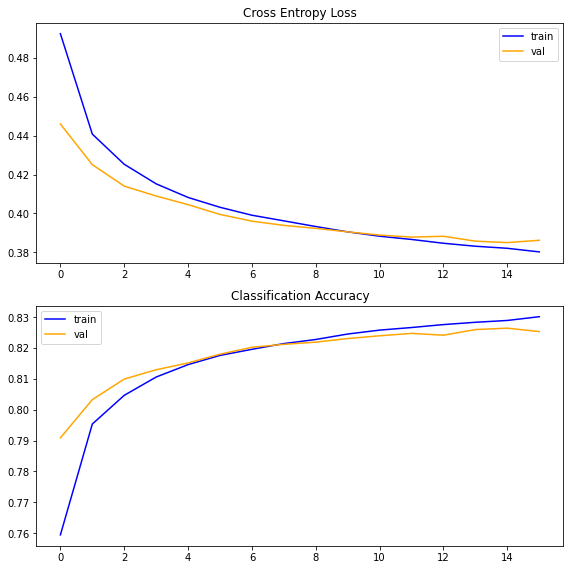

In [42]:
summarize_diagnostics(history)

### Evaluate

In [43]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [44]:
model.evaluate(X_test_ready, y_test)

4540/4540 [==============================] - 24s 5ms/step - loss: 0.3850 - accuracy: 0.8264


[0.38502031564712524, 0.826445460319519]

In [45]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB7(raw_txt)
model.predict(raw_txt)

array([[0.03538138],
       [0.975183  ]], dtype=float32)

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- ArchiREF ---------------------------------------------------------------------------------------

             ROC_AUC : 0.9075
                  F1 : 0.8256
            ACCURACY : 0.8264
           PRECISION : 0.8237
              RECALL : 0.8275
   AVERAGE_PRECISION : 0.9081

       TRAINING-TIME : 444.8095
      INFERENCE-TIME : 42.5195

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.83      0.83      0.83     73165
Prediction = 1       0.82      0.83      0.83     72115

      accuracy                           0.83    145280
     macro avg     

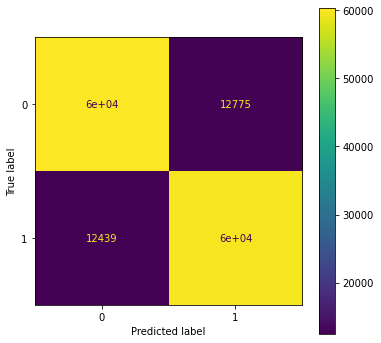

--- ROC AUC ---------------------------------------------------------------------------------------- 



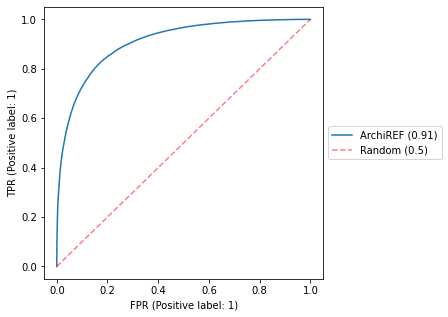

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



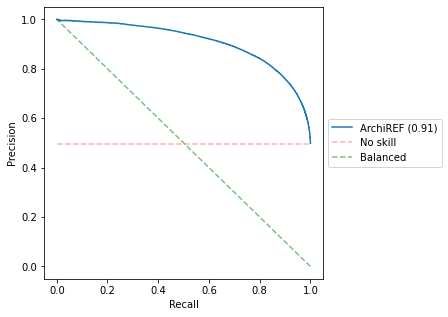

In [46]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [47]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

The best Accuracy score (0.8265487334801762) for this model is reached with a threshold of 0.512


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- ArchiREF [w. threshold] ------------------------------------------------------------------------

             ROC_AUC : 0.9075
                  F1 : 0.8248
            ACCURACY : 0.8268
           PRECISION : 0.8283
              RECALL : 0.8212
   AVERAGE_PRECISION : 0.9081

       TRAINING-TIME : 444.8095
      INFERENCE-TIME : 20.4983

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.83      0.83      0.83     73165
Prediction = 1       0.83      0.82      0.82     72115

      accuracy                           0.83    145280
     macro avg     

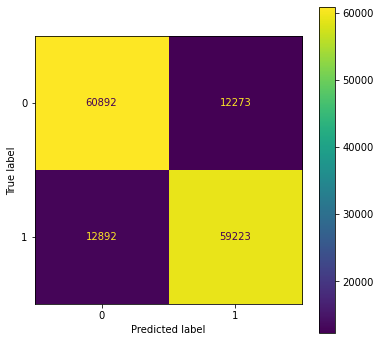

In [48]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [49]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [50]:
from classification_utils import scores_df
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,ArchiREF,0.500,None,0.907486,0.908087,0.825588,0.826445,0.823674,0.827512,59676,60390,12775,12439,444.809509,42.519483
1,ArchiREF [w. threshold],0.512,None,0.907486,0.908087,0.824770,0.826783,0.828340,0.821230,59223,60892,12273,12892,444.809509,20.498286


---
## 2.2 `Archi-000` Dense 32 + Dropout 0.5 <a class="anchor" id="ARCHI_000"></a> [⇪](#menu)

In [51]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
    name="embedding_GloVe_Twitter_200d",
)

In [52]:
model_name = "Archi000"
model, archi_desc = architecture000("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [53]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 60)]              0         
                                                                 
 dense (Dense)               (None, 32)                1952      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 predictions (Dense)         (None, 1)                 33        
                                                                 
Total params: 1,985
Trainable params: 1,985
Non-trainable params: 0
_________________________________________________________________


#### Définissons un logger DagsHub pour enregistrer notre essai

In [54]:
dagslogger = DAGsHubLogger()

In [55]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [56]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=100, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

Epoch 1/100
278/284 [============================>.] - ETA: 0s - loss: 139.8897 - accuracy: 0.5074
Epoch 1: val_accuracy improved from -inf to 0.51685, saving model to models/Archi000.keras
284/284 [==============================] - 2s 6ms/step - loss: 137.3533 - accuracy: 0.5075 - val_loss: 8.1067 - val_accuracy: 0.5169
Epoch 2/100
283/284 [============================>.] - ETA: 0s - loss: 3.8295 - accuracy: 0.5084
Epoch 2: val_accuracy did not improve from 0.51685
284/284 [==============================] - 2s 6ms/step - loss: 3.8224 - accuracy: 0.5084 - val_loss: 0.9257 - val_accuracy: 0.5045
Epoch 3/100
280/284 [============================>.] - ETA: 0s - loss: 0.8707 - accuracy: 0.5060
Epoch 3: val_accuracy did not improve from 0.51685
284/284 [==============================] - 2s 5ms/step - loss: 0.8692 - accuracy: 0.5060 - val_loss: 0.7402 - val_accuracy: 0.5125
Epoch 4/100
283/284 [============================>.] - ETA: 0s - loss: 0.7358 - accuracy: 0.5048
Epoch 4: val_accuracy 

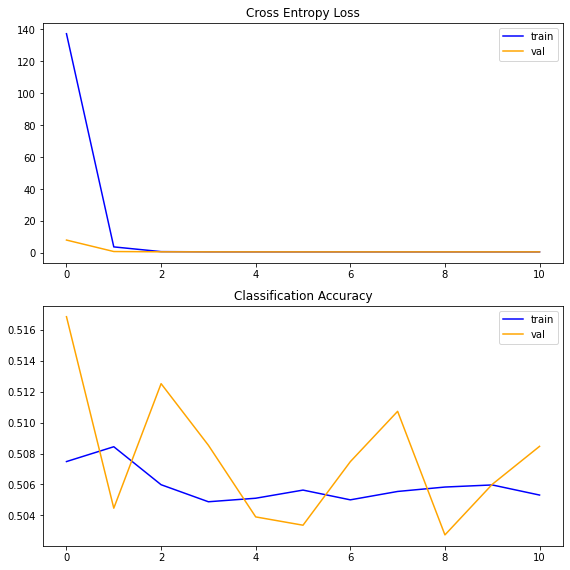

In [57]:
summarize_diagnostics(history)

### Evaluate

In [58]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [59]:
model.evaluate(X_test_ready, y_test)

4540/4540 [==============================] - 9s 2ms/step - loss: 8.1067 - accuracy: 0.5169


[8.106690406799316, 0.5168502330780029]

In [60]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB7(raw_txt)
model.predict(raw_txt)

array([[0.5763336],
       [0.5108154]], dtype=float32)

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Archi000 ---------------------------------------------------------------------------------------

             ROC_AUC : 0.5163
                  F1 : 0.4842
            ACCURACY : 0.5169
           PRECISION : 0.5150
              RECALL : 0.4568
   AVERAGE_PRECISION : 0.5084

       TRAINING-TIME : 18.0467
      INFERENCE-TIME : 10.2803

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.52      0.58      0.55     73165
Prediction = 1       0.52      0.46      0.48     72115

      accuracy                           0.52    145280
     macro avg      

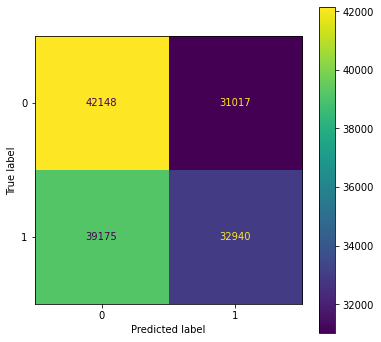

--- ROC AUC ---------------------------------------------------------------------------------------- 



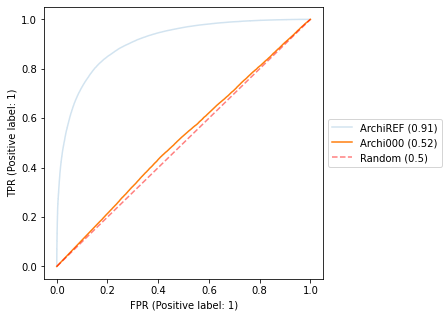

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



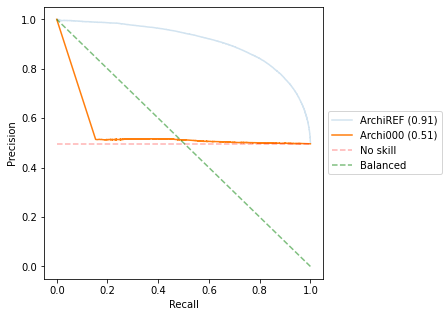

In [61]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [62]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

The best Accuracy score (0.516210077092511) for this model is reached with a threshold of 0.509


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Archi000 [w. threshold] ------------------------------------------------------------------------

             ROC_AUC : 0.5163
                  F1 : 0.4752
            ACCURACY : 0.5170
           PRECISION : 0.5158
              RECALL : 0.4406
   AVERAGE_PRECISION : 0.5084

       TRAINING-TIME : 18.0467
      INFERENCE-TIME : 6.2174

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.52      0.59      0.55     73165
Prediction = 1       0.52      0.44      0.48     72115

      accuracy                           0.52    145280
     macro avg       

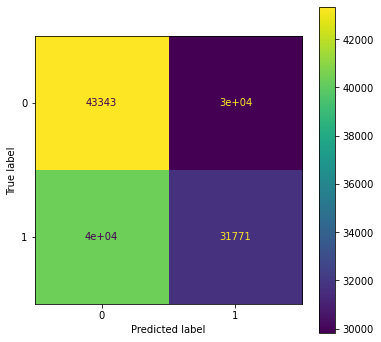

In [63]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [64]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [65]:
from classification_utils import scores_df
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,ArchiREF,0.500,None,0.907486,0.908087,0.825588,0.826445,0.823674,0.827512,59676,60390,12775,12439,444.809509,42.519483
1,ArchiREF [w. threshold],0.512,None,0.907486,0.908087,0.824770,0.826783,0.828340,0.821230,59223,60892,12273,12892,444.809509,20.498286
2,Archi000,0.500,None,0.516288,0.508409,0.484155,0.516850,0.515034,0.456770,32940,42148,31017,39175,18.046688,10.280299
3,Archi000 [w. threshold],0.509,None,0.516288,0.508409,0.475230,0.517029,0.515822,0.440560,31771,43343,29822,40344,18.046688,6.217441


---
## 2.3 `Archi-100` Simple RNN 32 + Dropout 0.5 <a class="anchor" id="ARCHI_100"></a> [⇪](#menu)

In [ ]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
    name="embedding_GloVe_Twitter_200d",
)

In [ ]:
model_name = "Archi100"
model, archi_desc = architecture100("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [ ]:
model.summary()

#### Définissons un logger DagsHub pour enregistrer notre essai

In [ ]:
dagslogger = DAGsHubLogger()

In [ ]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [ ]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=100, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

In [ ]:
summarize_diagnostics(history)

### Evaluate

In [ ]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB7(raw_txt)
model.predict(raw_txt)

In [ ]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [ ]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

In [ ]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [ ]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [ ]:
from classification_utils import scores_df
scores_df

---
## 2.4 `Archi-200` LSTM 32 + Dropout 0.5 <a class="anchor" id="ARCHI_200"></a> [⇪](#menu)

In [ ]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
    name="embedding_GloVe_Twitter_200d",
)

In [ ]:
model_name = "Archi200"
model, archi_desc = architecture200("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [ ]:
model.summary()

#### Définissons un logger DagsHub pour enregistrer notre essai

In [ ]:
dagslogger = DAGsHubLogger()

In [ ]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [ ]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=100, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

In [ ]:
summarize_diagnostics(history)

### Evaluate

In [ ]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB7(raw_txt)
model.predict(raw_txt)

In [ ]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [ ]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

In [ ]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [ ]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [ ]:
from classification_utils import scores_df
scores_df

---
## 2.5 `Archi-300` GRU 32 + Dropout 0.5 <a class="anchor" id="ARCHI_300"></a> [⇪](#menu)

In [ ]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
    name="embedding_GloVe_Twitter_200d",
)

In [ ]:
model_name = "Archi300"
model, archi_desc = architecture300("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [ ]:
model.summary()

#### Définissons un logger DagsHub pour enregistrer notre essai

In [ ]:
dagslogger = DAGsHubLogger()

In [ ]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [ ]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=100, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

In [ ]:
summarize_diagnostics(history)

### Evaluate

In [ ]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB7(raw_txt)
model.predict(raw_txt)

In [ ]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [ ]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

In [ ]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [ ]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [ ]:
from classification_utils import scores_df
scores_df

---
## 2.6 `Archi-201` Bi-LSTM 64 + Dropout 0.5 <a class="anchor" id="ARCHI_201"></a> [⇪](#menu)

In [ ]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
    name="embedding_GloVe_Twitter_200d",
)

In [ ]:
model_name = "Archi201"
model, archi_desc = architecture201("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [ ]:
model.summary()

#### Définissons un logger DagsHub pour enregistrer notre essai

In [ ]:
dagslogger = DAGsHubLogger()

In [ ]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [ ]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=100, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

In [ ]:
summarize_diagnostics(history)

### Evaluate

In [ ]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB7(raw_txt)
model.predict(raw_txt)

In [ ]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [ ]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

In [ ]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [ ]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [ ]:
from classification_utils import scores_df
scores_df

---
## 2.7 `Archi-202` Bi-LSTM 64 + Dense 24 <a class="anchor" id="ARCHI_202"></a> [⇪](#menu)

In [ ]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
    name="embedding_GloVe_Twitter_200d",
)

In [ ]:
model_name = "Archi202"
model, archi_desc = architecture202("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [ ]:
model.summary()

#### Définissons un logger DagsHub pour enregistrer notre essai

In [ ]:
dagslogger = DAGsHubLogger()

In [ ]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [ ]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=100, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

In [ ]:
summarize_diagnostics(history)

### Evaluate

In [ ]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB7(raw_txt)
model.predict(raw_txt)

In [ ]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [ ]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

In [ ]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [ ]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [ ]:
from classification_utils import scores_df
scores_df

---
## 2.8 `Archi-301` Bi-GRU 64 + Dropout 0.5 <a class="anchor" id="ARCHI_301"></a> [⇪](#menu)

In [ ]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
    name="embedding_GloVe_Twitter_200d",
)

In [ ]:
model_name = "Archi301"
model, archi_desc = architecture301("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [ ]:
model.summary()

#### Définissons un logger DagsHub pour enregistrer notre essai

In [ ]:
dagslogger = DAGsHubLogger()

In [ ]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [ ]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=100, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

In [ ]:
summarize_diagnostics(history)

### Evaluate

In [ ]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB7(raw_txt)
model.predict(raw_txt)

In [ ]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [ ]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

In [ ]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [ ]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [ ]:
from classification_utils import scores_df
scores_df

---
## 2.9 `Archi-302` Bi-GRU 64 + Dense 24 <a class="anchor" id="ARCHI_302"></a> [⇪](#menu)

In [ ]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
    name="embedding_GloVe_Twitter_200d",
)

In [ ]:
model_name = "Archi302"
model, archi_desc = architecture302("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [ ]:
model.summary()

#### Définissons un logger DagsHub pour enregistrer notre essai

In [ ]:
dagslogger = DAGsHubLogger()

In [ ]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [ ]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=100, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

In [ ]:
summarize_diagnostics(history)

### Evaluate

In [ ]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB7(raw_txt)
model.predict(raw_txt)

In [ ]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [ ]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

In [ ]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [ ]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [ ]:
from classification_utils import scores_df
scores_df

---
## 2.10 `Archi-401` Bi-LSTM 32 + Dense 10 <a class="anchor" id="ARCHI_401"></a> [⇪](#menu)

In [ ]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
    name="embedding_GloVe_Twitter_200d",
)

In [ ]:
model_name = "Archi401"
model, archi_desc = architecture401("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [ ]:
model.summary()

#### Définissons un logger DagsHub pour enregistrer notre essai

In [ ]:
dagslogger = DAGsHubLogger()

In [ ]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [ ]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=100, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

In [ ]:
summarize_diagnostics(history)

### Evaluate

In [ ]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB7(raw_txt)
model.predict(raw_txt)

In [ ]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [ ]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

In [ ]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [ ]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [ ]:
from classification_utils import scores_df
scores_df

---
## 2.11 `Archi-402` Bi-LSTM 64 Seq + Dropout 0.2 + Bi-LSTM 32 + Dropout 0.2 + Dense 64 + Dropout 0.1 <a class="anchor" id="ARCHI_402"></a> [⇪](#menu)

In [ ]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
    name="embedding_GloVe_Twitter_200d",
)

In [ ]:
model_name = "Archi402"
model, archi_desc = architecture402("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [ ]:
model.summary()

#### Définissons un logger DagsHub pour enregistrer notre essai

In [ ]:
dagslogger = DAGsHubLogger()

In [ ]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [ ]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=100, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

In [ ]:
summarize_diagnostics(history)

### Evaluate

In [ ]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB7(raw_txt)
model.predict(raw_txt)

In [ ]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [ ]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

In [ ]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [ ]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [ ]:
from classification_utils import scores_df
scores_df

---
## 2.12 Comparaison des `scores` avec les différentes architectures <a class="anchor" id="ARCHI_scores"></a> [⇪](#menu)

In [ ]:
from classification_utils import scores_df

In [ ]:
scores_df.sort_values(['ROC AUC'], ascending=False)

In [ ]:
scores_df.sort_values(['Accuracy'], ascending=False)